**This will reflect the algorithm used in analysis.js**

In [74]:
from collections import Counter, namedtuple
from matplotlib import pyplot as plt
import numpy as np
import json
import os
import re

In [75]:
def print_counter_top(ct, N):
    ans = sorted(ct.items(), key=lambda x:x[1], reverse=True)
    for k, v in ans[:N]:
        print(v / 1e6, k)
def get_counter_top(ct, N):
    ans = sorted(ct.items(), key=lambda x:x[1], reverse=True)
    for k, v in ans[:N]:
        yield k

In [76]:
def getFcallsInfo(fname, verbose=False):
    vprint = print if verbose else lambda *_,**__: None
    
    with open(fname) as f:
        raw = json.load(f)

    # Find all JS function calls
    fcalls = [x for x in raw if x['name'] == 'FunctionCall']
    fcalls_by_ids = {}
    for c in fcalls:
        key = '{}-{}'.format(c['pid'], c['tid'])
        fcalls_by_ids.setdefault(key, []).append(c)

    for k, v in fcalls_by_ids.items():
        # See https://docs.google.com/document/d/1CvAClvFfyA5R-PhYUmn5OOQtYMH4h6I0nSsKchNAySU/preview
        # It mentioned how  Duration Events work.
        # But it never confirmed that 'FunctionCall' events do not nest when pid&tid do not change
        # This confirms that they do not nest
        vprint('Checking sanity of', k)
        assert('BB' not in ''.join(x['ph'] for x in v))
        assert('EE' not in ''.join(x['ph'] for x in v))
        if v[0]['ph'] =='B':
            assert ''.join(x['ph'] for x in v[:2*(len(v)//2)]) == 'BE' * (len(v)//2)
        if v[0]['ph'] =='E':
            assert ''.join(x['ph'] for x in v[1:2*(len(v)//2 + 1) - 1]) == 'BE' * (len(v)//2)
        vprint(' + this thread checks out')
        if len(v) %2 != 0:
            vprint(' * remaining event: ', v[-1]['ph'])
    vprint('OK')
    return fcalls_by_ids

In [77]:
def fcall_time_range(fcalls, timestamp_key='ts'):
    _min = min(
        int(y.get(timestamp_key))
        for x in fcalls.values()
        for y in x
        if y.get(timestamp_key) is not None
    )
    _max = max(
        int(y.get(timestamp_key))
        for x in fcalls.values()
        for y in x
        if y.get(timestamp_key) is not None
    )
    return _min, _max

In [91]:
def getCounters(fcalls_by_ids, time_slice_size=None):
    # Aggregate info about JS Function calls
    start_time, end_time = fcall_time_range(
        fcalls_by_ids, 
        timestamp_key='ts'
    )
    num_time_slice = (end_time-start_time)//time_slice_size + 1 if time_slice_size else 1
    
    callFrames = [Counter() for _ in range(num_time_slice)]
    callFunctionNames = [Counter() for _ in range(num_time_slice)]
    callURLs = [Counter() for _ in range(num_time_slice)]

    for k, v in fcalls_by_ids.items(): 
        if v[0]['ph'] == 'E':
            if len(v) < 2:
                return None
            assert v[1]['ph'] == 'B'
            v = v[1:]
        bs = [x for i, x in enumerate(v) if i % 2 == 0]
        es = [x for i, x in enumerate(v) if i % 2 != 0]
        for b, e in zip(bs, es):
            assert b['ph'] == 'B'
            assert e['ph'] == 'E'
            info = b.get('args', {}).get('data', {})
            info2 = e.get('args', {}).get('data', {})
            assert info.get('functionName') == info2.get('functionName') \
                or (not info2.get('functionName'))
            info.update(info2)
            if not info: continue
                
            frame = info.get('frame')
            funcName = info.get('functionName')
            url = info.get('url')
            
            bts = b.get('ts')
            ets = e.get('ts')
            if time_slice_size:
                ts = bts
                while ts < ets:
                    slice_id = (ts - start_time) // time_slice_size

                    duration = min(ets, start_time + (slice_id + 1) * time_slice_size - 1) - ts
                    callFrames[slice_id][frame] += duration
                    callFunctionNames[slice_id][funcName] += duration
                    callURLs[slice_id][url] += duration
                    ts = start_time + (slice_id + 1) * time_slice_size
            else:
                callFrames[0][frame] += ets - bts
                callFunctionNames[0][funcName] += ets - bts
                callURLs[0][url] += ets - bts

    if time_slice_size:
        return callFrames, callFunctionNames, callURLs
    return callFrames[0], callFunctionNames[0], callURLs[0]

In [79]:
# cpus: list of cpu usages
AnalysisCtx = namedtuple('AnalysisCtx', ['cpus', 'time_slice_size'])

In [80]:
def get_timeline_for(counters, key, _ctx):
    data = []
    tlen = len(counters)
    for tid, c in enumerate(counters):
        curr_cpu = _ctx.cpus[len(_ctx.cpus) * tid // tlen]
        
        # !!! DEBUG ONLY
        curr_cpu = np.average(_ctx.cpus)
        
        if c is None:
            data.append(0)
            continue
        data.append(c.get(key, 0) / _ctx.time_slice_size / curr_cpu)
    return np.array(data)

In [81]:
def plot_counters(sliced_counters, full_counters, _ctx):
    configs = [
        (0, "by frame"),
        (1, "by func name"),
        (2, "by url"),
    ]
    for info_idx, plot_name in configs:
        for k in get_counter_top(full_counters[info_idx], 5):
            data = get_timeline_for(sliced_counters[info_idx], k, _ctx)
            label = str(k)[:50]
            if not label:
                label = "(empty string)"
            plt.plot(data, label=label)

        plt.legend()
        plt.title(plot_name)
        plt.ylabel("JS CPU%, divided by curr process CPU%")
        plt.show()

In [82]:
whitelist=[
    #'^http(s)?://[a-zA-Z0-9\-_]+\.googleapis.com/',
    #'^http(s)?://[a-zA-Z0-9\-_]+\.googlesyndication.com/',
    #'^http(s)?://[a-zA-Z0-9\-_]+\.addthis.com/',   # By Oracle
    #'^http(s)?://[a-zA-Z0-9\-_]+\.ytimg.com/',     # By Google
]

def in_whitelist(url):
    for x in whitelist:
        if re.match(x, url, flags=re.IGNORECASE):
            return True
    return False

In [83]:
epsilon = 1e-5

def analyze(fname_prefix, N_top_result=5, time_resolution=int(1e4), verbose=False):
    vprint = print if verbose else lambda *_,**__: None
    with open(fname_prefix+'-usage.json') as f:
        usages = json.load(f)
        cpus = [x['cpu'] for x in usages]
        avg_cpu = np.average(cpus)
    vprint("AVERAGE CPU (INFO ONLY):", avg_cpu)
    fcalls_by_ids = getFcallsInfo(fname_prefix+'-tracing.json', verbose=verbose)
    counters = getCounters(fcalls_by_ids, time_slice_size=time_resolution)
    full_counters = getCounters(fcalls_by_ids)
    
    ctx = AnalysisCtx(cpus=cpus, time_slice_size=time_resolution)
    
    # Generate basic plots
    plot_counters(counters, full_counters, ctx)
    
    # Pay special attention to None frames
    none_frame = get_timeline_for(counters[0], None, ctx)
    none_frame = sum(none_frame > 0.02) / len(none_frame)
    vprint("NONE FRAME SCORE:", none_frame)
    if none_frame >= 0.2:
        pass
        #vprint('RESULT: Malicious.')
        #return 1
    if none_frame >= 0.01:
        pass
        #vprint('RESULT: SUSPICIOUS.')
        #return 2
    
    # General predictions based on JS CPU usages
    # (if one function/url uses CPU for 
    #  a percentage of time, consistently,
    #  then suspicous)
    fnames = {}
    urls = {}
    for ans, isrc in [(fnames, 1), (urls, 2)]:
        for key in full_counters[isrc].keys():
            timeline = get_timeline_for(
                counters[isrc], key, ctx
            )
            ans[key] = sum(timeline > 0.1) / len(timeline)
    
    # You can choose to show a histogram here, for debugging
    if False:
        plt.hist(list(fnames.values()), label="based on fnames")
        plt.hist(list(urls.values()), label="based on urls")
        plt.title("Histogram of scores")
        plt.legend()
        plt.show()
    
    indicator = [(y, u) for u, y in urls.items() if not in_whitelist(u)]
    vprint("MAX SUSPICION INDICATOR SCORE: ", max(indicator, key=lambda x:x[0]))
    indicator = [(x, n) for x, n in indicator if x > 0]
    if indicator:
        print(indicator)
        vprint("RESULT: SUSPICIOUS")
        return 2
    
    vprint("RESULT: SAFE")
    return 3

In [84]:
def basename(x, y):
    if x.endswith(y):
        return x[:-len(y)]
    return x

def all_logs_in(folder):
    all_names = [os.path.join(folder,x) for x in os.listdir(folder)]
    all_names = [
        basename(basename(x, '-tracing.json'), '-usage.json')
        for x in all_names
    ]
    return sorted(set(all_names))

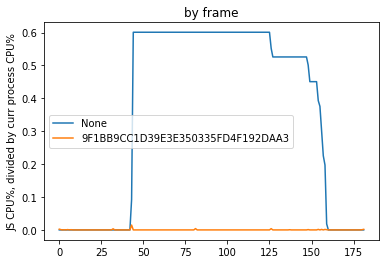

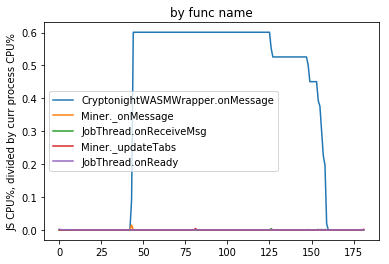

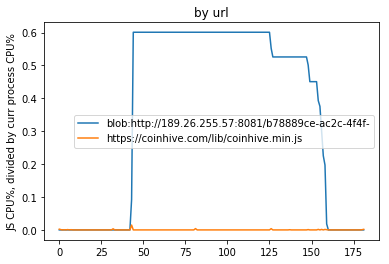

[(0.6318681318681318, 'blob:http://189.26.255.57:8081/b78889ce-ac2c-4f4f-9b3f-e9c5e169e97c')]


2

In [92]:
analyze('mbp-normal/9-mal-1524968494')

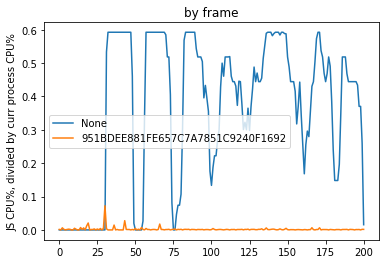

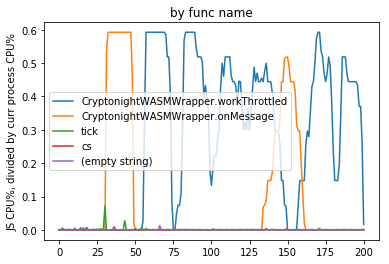

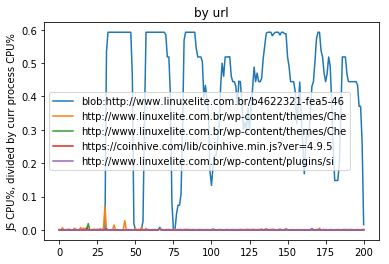

[(0.7761194029850746, 'blob:http://www.linuxelite.com.br/b4622321-fea5-460d-afc3-f4ed0720ab1e')]
2 mbp-normal/1-mal-1524968494


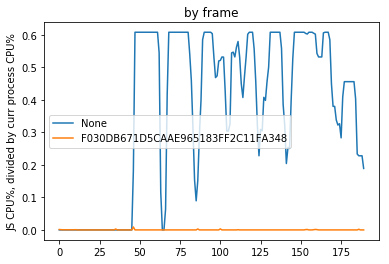

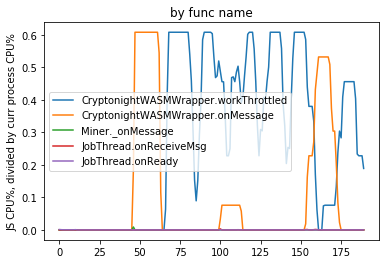

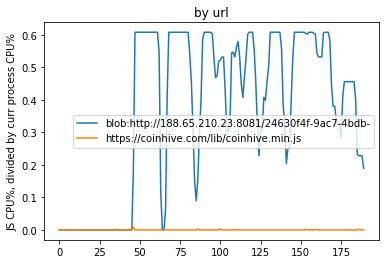

[(0.7368421052631579, 'blob:http://188.65.210.23:8081/24630f4f-9ac7-4bdb-8fdf-e59e631034c8')]
2 mbp-normal/10-mal-1524968494


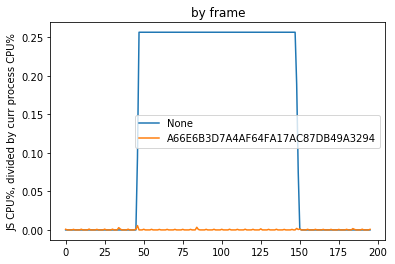

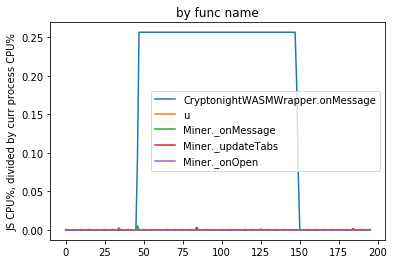

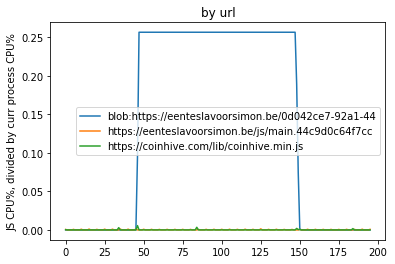

[(0.5204081632653061, 'blob:https://eenteslavoorsimon.be/0d042ce7-92a1-44bb-b71f-403231350224')]
2 mbp-normal/2-mal-1524968494


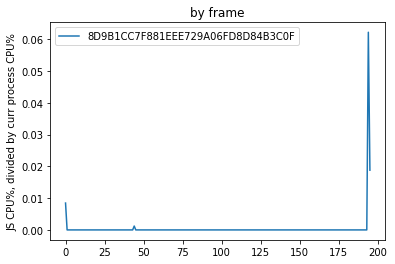

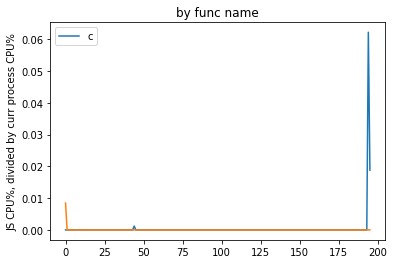

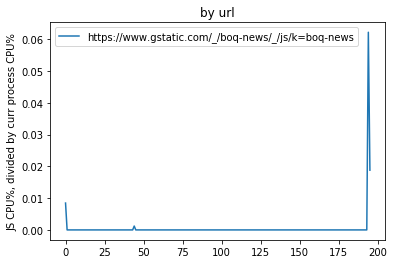

3 mbp-normal/3-good-1524968494


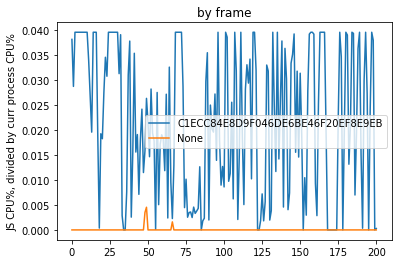

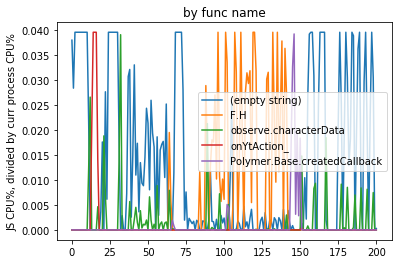

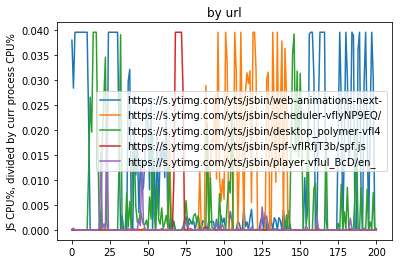

3 mbp-normal/4-good-vid-1524968494


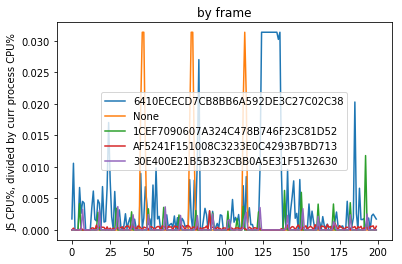

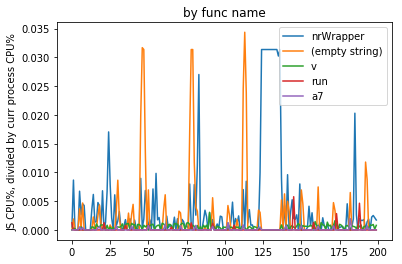

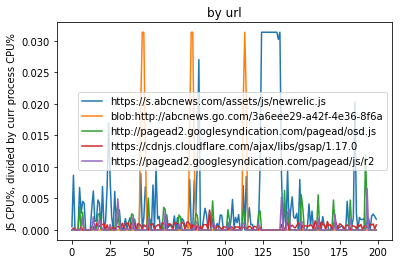

3 mbp-normal/5-good-ad-1524968494


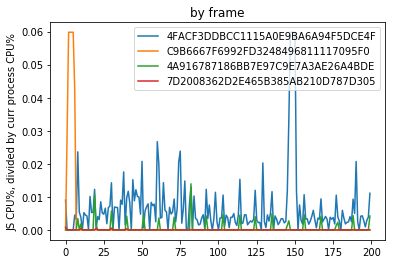

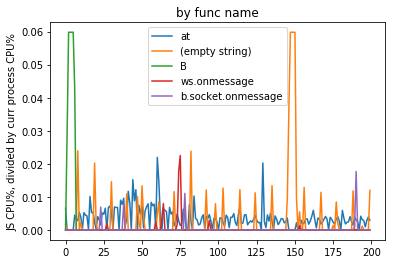

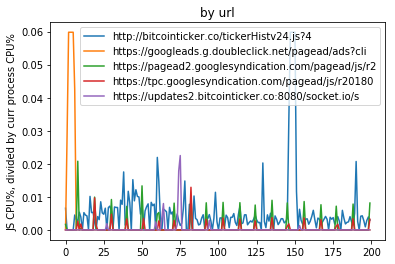

3 mbp-normal/6-good-ui-1524968494


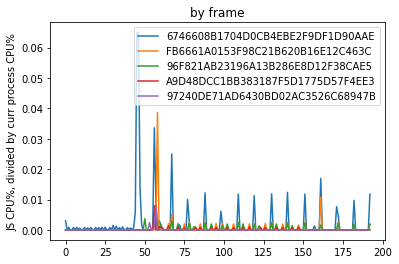

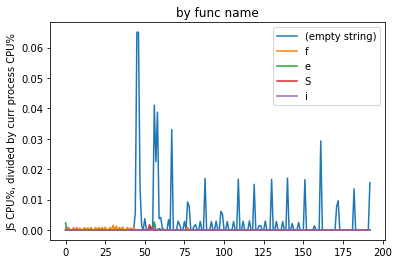

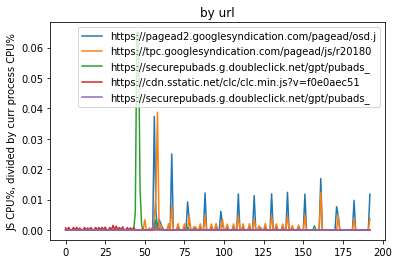

3 mbp-normal/7-good-1524968494


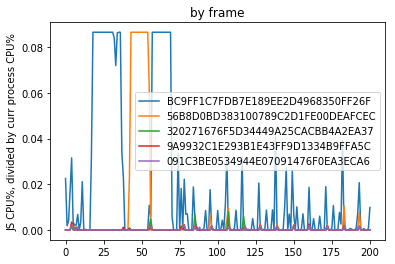

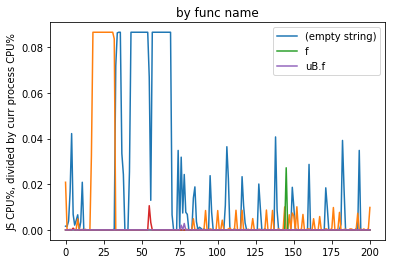

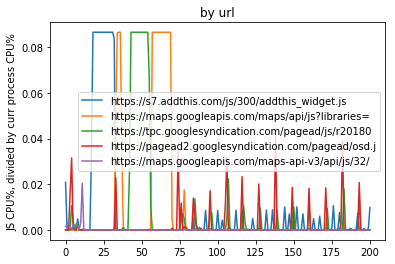

3 mbp-normal/8-good-1524968494


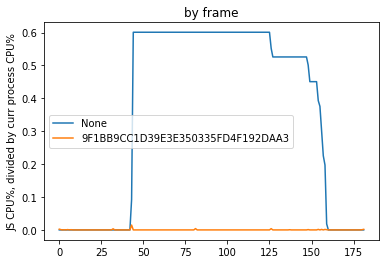

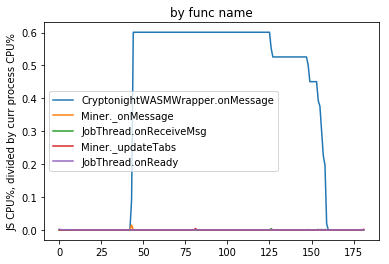

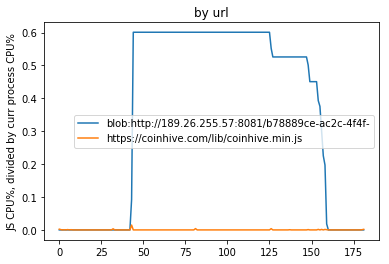

[(0.6318681318681318, 'blob:http://189.26.255.57:8081/b78889ce-ac2c-4f4f-9b3f-e9c5e169e97c')]
2 mbp-normal/9-mal-1524968494


In [93]:
for log in all_logs_in('mbp-normal/'):
    print(analyze(log), log)

In [ ]:
for log in all_logs_in('deploy-1vpu-1G-normal/'):
    print(analyze(log), log)

In [ ]:

for log in all_logs_in('deploy-1vpu-1G-5threads/'):
    try:
        print(analyze(log), log)
    except:
        print("***ERR***", log)

In [ ]:

for log in all_logs_in('deploy-1vpu-1G-continous/'):
    try:
        print(analyze(log), log)
    except:
        print("***ERR***")